# Problem 1 Solution: Feature Engineering - Designing the Model's "Sensors"

This notebook contains complete solutions to all tasks in Problem 1. Use this to check your work or understand the intended approaches.

## Key Learning Points
- Features are the bridge between human language and mathematical computation
- Different feature sets capture different aspects of the data
- Good features make patterns more separable
- Feature engineering requires both domain knowledge and experimentation

In [27]:
# Setup and imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Dict, List
import re

# Import our custom utilities
import sys
sys.path.append('./utils')
from data_generators import load_sports_dataset, create_sports_tweets_features
from visualization import plot_feature_space_2d

# Load the dataset
features, labels, feature_names, texts = load_sports_dataset()

print("Loaded dataset:")
print(f"Features shape: {features.shape}")
print(f"Feature names: {feature_names}")
print(f"Sample texts: {texts[:3]}")

Loaded dataset:
Features shape: (16, 3)
Feature names: ['word_count', 'has_team', 'has_exclamation']
Sample texts: ['Go Dolphins!', 'Terrible game', 'Love the fins!']


## Task 1 Solution: Understanding the Baseline Features

In [28]:
# Examine the baseline features for our key example
go_dolphins_text = "Go Dolphins!"
go_dolphins_features = create_sports_tweets_features(go_dolphins_text)

print(f"Text: '{go_dolphins_text}'")
print("Features:")
for name, value in go_dolphins_features.items():
    print(f"  {name}: {value}")

print("\nFeature Vector: [{}]".format(", ".join(str(v) for v in go_dolphins_features.values())))

# Analyze all tweets
df = pd.DataFrame(features, columns=feature_names)
df['sentiment'] = ['Positive' if label == 1 else 'Negative' for label in labels]
df['text'] = texts

print("\nPattern Analysis:")
print("Positive tweets - average features:")
print(df[df['sentiment'] == 'Positive'][feature_names].mean())
print("\nNegative tweets - average features:")
print(df[df['sentiment'] == 'Negative'][feature_names].mean())

Text: 'Go Dolphins!'
Features:
  word_count: 2
  has_team: 1.0
  has_exclamation: 1.0

Feature Vector: [2, 1.0, 1.0]

Pattern Analysis:
Positive tweets - average features:
word_count         2.625
has_team           0.500
has_exclamation    1.000
dtype: float64

Negative tweets - average features:
word_count         2.5
has_team           0.0
has_exclamation    0.0
dtype: float64


## Task 2 Solutions: Feature Set Implementations

In [29]:
def feature_set_1_emotional_words(text: str) -> Dict[str, float]:
    """
    Feature Set 1: Focus on emotional words
    """
    text_lower = text.lower()
    words = text_lower.split()
    
    # Positive emotional words
    positive_words = ['amazing', 'great', 'love', 'best', 'incredible', 'fantastic', 'awesome', 'win', 'perfect']
    
    # Negative emotional words  
    negative_words = ['terrible', 'bad', 'awful', 'worst', 'hate', 'horrible', 'disappointing', 'sucks']
    
    # Count positive and negative words
    pos_count = sum(1 for word in words if word in positive_words)
    neg_count = sum(1 for word in words if word in negative_words)
    
    # Calculate emotional intensity
    total_words = len(words)
    emotional_intensity = (pos_count + neg_count) / max(total_words, 1)
    
    features = {
        'positive_word_count': float(pos_count),
        'negative_word_count': float(neg_count),
        'emotional_intensity': emotional_intensity,
        'sentiment_balance': pos_count - neg_count,  # Net sentiment
    }
    
    return features

# Test implementation
test_texts = ["Amazing game! Love the Dolphins!", "Terrible performance, worst team ever"]
for text in test_texts:
    result = feature_set_1_emotional_words(text)
    print(f"'{text}': {result}")

'Amazing game! Love the Dolphins!': {'positive_word_count': 2.0, 'negative_word_count': 0.0, 'emotional_intensity': 0.4, 'sentiment_balance': 2}
'Terrible performance, worst team ever': {'positive_word_count': 0.0, 'negative_word_count': 2.0, 'emotional_intensity': 0.4, 'sentiment_balance': -2}


In [30]:
def feature_set_2_text_style(text: str) -> Dict[str, float]:
    """
    Feature Set 2: Focus on text style and formatting
    """
    
    # Calculate capitalization ratio
    letters = [c for c in text if c.isalpha()]
    cap_ratio = sum(1 for c in letters if c.isupper()) / max(len(letters), 1)
    
    # Count total punctuation marks
    punctuation = '!?.,;:'
    punct_count = sum(1 for c in text if c in punctuation)
    
    # Calculate average word length
    words = text.split()
    avg_word_len = sum(len(word.strip('!?.,;:')) for word in words) / max(len(words), 1)
    
    # Check for repeated punctuation
    has_repeated = 1.0 if ('!!' in text or '??' in text or '..' in text) else 0.0
    
    features = {
        'capitalization_ratio': cap_ratio,
        'punctuation_count': float(punct_count),
        'avg_word_length': avg_word_len,
        'has_repeated_punctuation': has_repeated,
    }
    
    return features

# Test implementation
test_texts = ["AMAZING GAME!!!", "Bad coaching decision."]
for text in test_texts:
    result = feature_set_2_text_style(text)
    print(f"'{text}': {result}")

'AMAZING GAME!!!': {'capitalization_ratio': 1.0, 'punctuation_count': 3.0, 'avg_word_length': 5.5, 'has_repeated_punctuation': 1.0}
'Bad coaching decision.': {'capitalization_ratio': 0.05263157894736842, 'punctuation_count': 1.0, 'avg_word_length': 6.333333333333333, 'has_repeated_punctuation': 0.0}


In [31]:
def feature_set_3_sports_domain(text: str) -> Dict[str, float]:
    """
    Feature Set 3: Sports-specific domain knowledge
    """
    text_lower = text.lower()
    
    # Team references (official and nicknames)
    team_terms = ['dolphins', 'fins', 'phins', 'miami', 'team']
    has_team = 1.0 if any(term in text_lower for term in team_terms) else 0.0
    
    # Sports action words
    action_words = ['win', 'game', 'play', 'season', 'touchdown', 'score', 'coaching']
    action_count = sum(1 for word in action_words if word in text_lower)
    
    # Performance indicators
    positive_performance = ['win', 'great', 'amazing', 'incredible', 'fantastic', 'perfect']
    negative_performance = ['loss', 'lose', 'bad', 'terrible', 'awful', 'worst']
    
    pos_perf = sum(1 for word in positive_performance if word in text_lower)
    neg_perf = sum(1 for word in negative_performance if word in text_lower)
    
    # Check for scores or numbers (might indicate game results)
    has_numbers = 1.0 if re.search(r'\d', text) else 0.0
    
    features = {
        'has_team_reference': has_team,
        'sports_action_count': float(action_count),
        'positive_performance': float(pos_perf),
        'negative_performance': float(neg_perf),
        'has_numbers': has_numbers,
    }
    
    return features

# Test implementation
test_texts = ["Dolphins win 28-7!", "Terrible coaching this season"]
for text in test_texts:
    result = feature_set_3_sports_domain(text)
    print(f"'{text}': {result}")

'Dolphins win 28-7!': {'has_team_reference': 1.0, 'sports_action_count': 1.0, 'positive_performance': 1.0, 'negative_performance': 0.0, 'has_numbers': 1.0}
'Terrible coaching this season': {'has_team_reference': 0.0, 'sports_action_count': 2.0, 'positive_performance': 0.0, 'negative_performance': 1.0, 'has_numbers': 0.0}


In [32]:
def feature_set_4_linguistic(text: str) -> Dict[str, float]:
    """
    Feature Set 4: Linguistic patterns and structure
    """
    text_lower = text.lower()
    words = text_lower.split()
    
    # Negation detection
    negation_words = ['not', 'no', 'never', 'nothing', "n't", "don't", "can't"]
    has_negation = 1.0 if any(neg in text_lower for neg in negation_words) else 0.0
    
    # Comparative and superlative forms
    comparatives = ['better', 'worse', 'more', 'less', 'best', 'worst', 'most', 'least']
    has_comparison = 1.0 if any(comp in text_lower for comp in comparatives) else 0.0
    
    # Question vs statement
    is_question = 1.0 if '?' in text else 0.0
    
    # Intensifiers
    intensifiers = ['very', 'really', 'so', 'extremely', 'incredibly', 'absolutely']
    intensifier_count = sum(1 for word in words if word in intensifiers)
    
    # Personal pronouns (engagement level)
    pronouns = ['i', 'we', 'my', 'our', 'me', 'us']
    pronoun_count = sum(1 for word in words if word in pronouns)
    
    features = {
        'has_negation': has_negation,
        'has_comparison': has_comparison,
        'is_question': is_question,
        'intensifier_count': float(intensifier_count),
        'personal_pronoun_count': float(pronoun_count),
    }
    
    return features

# Test implementation
test_texts = ["I really love this team!", "Can't believe how bad they are"]
for text in test_texts:
    result = feature_set_4_linguistic(text)
    print(f"'{text}': {result}")

'I really love this team!': {'has_negation': 0.0, 'has_comparison': 0.0, 'is_question': 0.0, 'intensifier_count': 1.0, 'personal_pronoun_count': 1.0}
'Can't believe how bad they are': {'has_negation': 1.0, 'has_comparison': 0.0, 'is_question': 0.0, 'intensifier_count': 0.0, 'personal_pronoun_count': 0.0}


In [33]:
def feature_set_5_creative(text: str) -> Dict[str, float]:
    """
    Feature Set 5: Creative combination - Sentiment velocity and context
    
    This combines multiple signals into composite features
    """
    text_lower = text.lower()
    words = text_lower.split()
    
    # Sentiment velocity: how quickly does sentiment change?
    pos_words = ['amazing', 'great', 'love', 'best', 'win', 'fantastic']
    neg_words = ['terrible', 'bad', 'hate', 'worst', 'awful', 'lose']
    
    # Track sentiment word positions
    sentiment_positions = []
    for i, word in enumerate(words):
        if word in pos_words:
            sentiment_positions.append((i, 1))  # positive
        elif word in neg_words:
            sentiment_positions.append((i, -1))  # negative
    
    # Calculate sentiment consistency
    if len(sentiment_positions) > 1:
        sentiments = [s[1] for s in sentiment_positions]
        sentiment_consistency = 1.0 if all(s == sentiments[0] for s in sentiments) else 0.0
    else:
        sentiment_consistency = 1.0
    
    # Emotional buildup (exclamations at end vs beginning)
    text_end = text[-3:] if len(text) >= 3 else text
    end_exclamations = text_end.count('!')
    
    # Word diversity (unique words / total words)
    unique_words = len(set(words))
    word_diversity = unique_words / max(len(words), 1)
    
    # Social engagement signals
    social_words = ['fans', 'everyone', 'team', 'we', 'us', 'together']
    social_engagement = sum(1 for word in words if word in social_words)
    
    features = {
        'sentiment_consistency': sentiment_consistency,
        'end_exclamations': float(end_exclamations),
        'word_diversity': word_diversity,
        'social_engagement': float(social_engagement),
        'composite_excitement': float(end_exclamations) * (1 + social_engagement),
    }
    
    return features

# Test implementation
test_texts = ["We love this amazing team!!!", "Bad game, terrible coaching, awful season"]
for text in test_texts:
    result = feature_set_5_creative(text)
    print(f"'{text}': {result}")

'We love this amazing team!!!': {'sentiment_consistency': 1.0, 'end_exclamations': 3.0, 'word_diversity': 1.0, 'social_engagement': 1.0, 'composite_excitement': 6.0}
'Bad game, terrible coaching, awful season': {'sentiment_consistency': 1.0, 'end_exclamations': 0.0, 'word_diversity': 1.0, 'social_engagement': 0.0, 'composite_excitement': 0.0}


## Task 3 Solution: Feature Set Evaluation

### 📚 **What are Separability and Fisher Ratio?**

Before we dive into code, let's understand what we're measuring:

**🎯 Separability**: How far apart are the average positive and negative tweets in feature space?
- Think of it like this: If positive tweets cluster around point A and negative tweets cluster around point B, separability is the distance between A and B
- Higher separability = easier for the model to tell positive from negative

**🔍 Fisher Ratio**: How well-separated are the classes relative to how spread out each class is?
- Formula: `Distance between class centers / Average spread within each class`
- Higher Fisher ratio = better features for classification
- It's like asking: "Are the two groups far apart AND tightly clustered?"

**🏀 Sports Analogy**: Imagine two basketball teams practicing:
- **High separability**: Teams practice on opposite sides of the gym
- **High Fisher ratio**: Teams practice far apart AND each team stays in a tight formation
- **Low Fisher ratio**: Teams might be far apart, but players are scattered everywhere

In [ ]:
# Apply each feature set to all tweets
feature_sets = {
    'Baseline': create_sports_tweets_features,
    'Emotional Words': feature_set_1_emotional_words,
    'Text Style': feature_set_2_text_style,
    'Sports Domain': feature_set_3_sports_domain,
    'Linguistic': feature_set_4_linguistic,
    'Creative': feature_set_5_creative,
}

# For beginners: Let's track our progress through the loop
results = {}
show_details = True  # Set to False to hide intermediate details

for loop_count, (name, feature_func) in enumerate(feature_sets.items(), 1):
    print(f"\n{'='*60}")
    print(f"🔄 LOOP {loop_count}/6: Evaluating {name} feature set...")
    print(f"{'='*60}")
    
    # STEP 1: Extract features for all tweets
    # This applies our feature function to every tweet in our dataset
    print("📝 STEP 1: Applying feature function to all tweets...")
    feature_dicts = [feature_func(text) for text in texts]
    
    if show_details and loop_count == 1:  # Show details only for first iteration
        print(f"   Example: First 3 feature dictionaries:")
        for i, (text, features) in enumerate(zip(texts[:3], feature_dicts[:3])):
            print(f"   Tweet {i+1}: '{text}' -> {features}")
    
    # STEP 2: Convert dictionaries to numpy arrays (needed for math operations)
    print("🔢 STEP 2: Converting to numerical arrays...")
    feature_names_set = list(feature_dicts[0].keys())  # Get feature names from first example
    
    # Convert list of dictionaries to 2D array: each row = one tweet, each column = one feature
    features_array = np.array([[d[fname] for fname in feature_names_set] for d in feature_dicts])
    
    if show_details and loop_count == 1:
        print(f"   Features array shape: {features_array.shape}")
        print(f"   Feature names: {feature_names_set}")
        print(f"   First few rows of features_array:")
        print(f"   {features_array[:3]}")
        print(f"   labels for first 3 tweets: {labels[:3]}")
    
    # STEP 3: Split data by positive vs negative labels
    print("📊 STEP 3: Separating positive and negative examples...")
    pos_mask = labels == 1  # Boolean array: True where tweet is positive
    neg_mask = labels == 0  # Boolean array: True where tweet is negative
    
    if show_details and loop_count == 1:
        print(f"   pos_mask: {pos_mask}")
        print(f"   neg_mask: {neg_mask}")
        print(f"   Number of positive tweets: {pos_mask.sum()}")
        print(f"   Number of negative tweets: {neg_mask.sum()}")
    
    # STEP 4: Calculate average features for each class (the "centers")
    print("🎯 STEP 4: Computing class centers (average features)...")
    pos_mean = features_array[pos_mask].mean(axis=0)  # Average across positive tweets
    neg_mean = features_array[neg_mask].mean(axis=0)  # Average across negative tweets
    
    if show_details and loop_count == 1:
        print(f"   Positive class center: {pos_mean}")
        print(f"   Negative class center: {neg_mean}")
        print(f"   Difference between centers: {pos_mean - neg_mean}")
    
    # STEP 5: Calculate separability (distance between centers)
    print("📏 STEP 5: Measuring separability...")
    separability = np.linalg.norm(pos_mean - neg_mean)  # Euclidean distance
    
    if show_details and loop_count == 1:
        print(f"   How to calculate separability:")
        print(f"   1. Subtract centers: {pos_mean} - {neg_mean} = {pos_mean - neg_mean}")
        print(f"   2. Take magnitude (length): ||{pos_mean - neg_mean}|| = {separability:.3f}")
    
    # STEP 6: Calculate how spread out each class is (variance)
    print("📈 STEP 6: Measuring within-class variance (spread)...")
    pos_var = np.mean(np.var(features_array[pos_mask], axis=0))  # How spread out are positive tweets?
    neg_var = np.mean(np.var(features_array[neg_mask], axis=0))  # How spread out are negative tweets?
    avg_variance = (pos_var + neg_var) / 2
    
    if show_details and loop_count == 1:
        print(f"   Positive class variance: {pos_var:.3f}")
        print(f"   Negative class variance: {neg_var:.3f}")
        print(f"   Average variance: {avg_variance:.3f}")
    
    # STEP 7: Calculate Fisher discriminant ratio
    print("🏆 STEP 7: Computing Fisher ratio...")
    fisher_ratio = separability / (avg_variance + 1e-10)  # Add tiny number to avoid division by zero
    
    if show_details and loop_count == 1:
        print(f"   Fisher ratio = separability / avg_variance")
        print(f"   Fisher ratio = {separability:.3f} / {avg_variance:.3f} = {fisher_ratio:.3f}")
        print(f"   Higher Fisher ratio = better features for classification!")
        show_details = False  # Only show details for first loop
    
    # Store results for this feature set
    results[name] = {
        'features': features_array,
        'feature_names': feature_names_set,
        'separability': separability,
        'fisher_ratio': fisher_ratio,
        'pos_mean': pos_mean,
        'neg_mean': neg_mean
    }
    
    # Summary for this feature set
    print(f"✅ RESULTS for {name}:")
    print(f"   🎯 Separability score: {separability:.3f}")
    print(f"   🏆 Fisher discriminant ratio: {fisher_ratio:.3f}")
    print(f"   📝 Features used: {feature_names_set}")

# FINAL RANKING
print(f"\n{'='*60}")
print("🏁 FINAL FEATURE SET RANKINGS:")
print(f"{'='*60}")

ranked_results = sorted(results.items(), key=lambda x: x[1]['fisher_ratio'], reverse=True)
for i, (name, result) in enumerate(ranked_results, 1):
    print(f"{i}. {name}: Fisher ratio = {result['fisher_ratio']:.3f}")

print(f"\n🎉 Winner: {ranked_results[0][0]} with Fisher ratio of {ranked_results[0][1]['fisher_ratio']:.3f}!")

## Task 4 Solution: Visualization

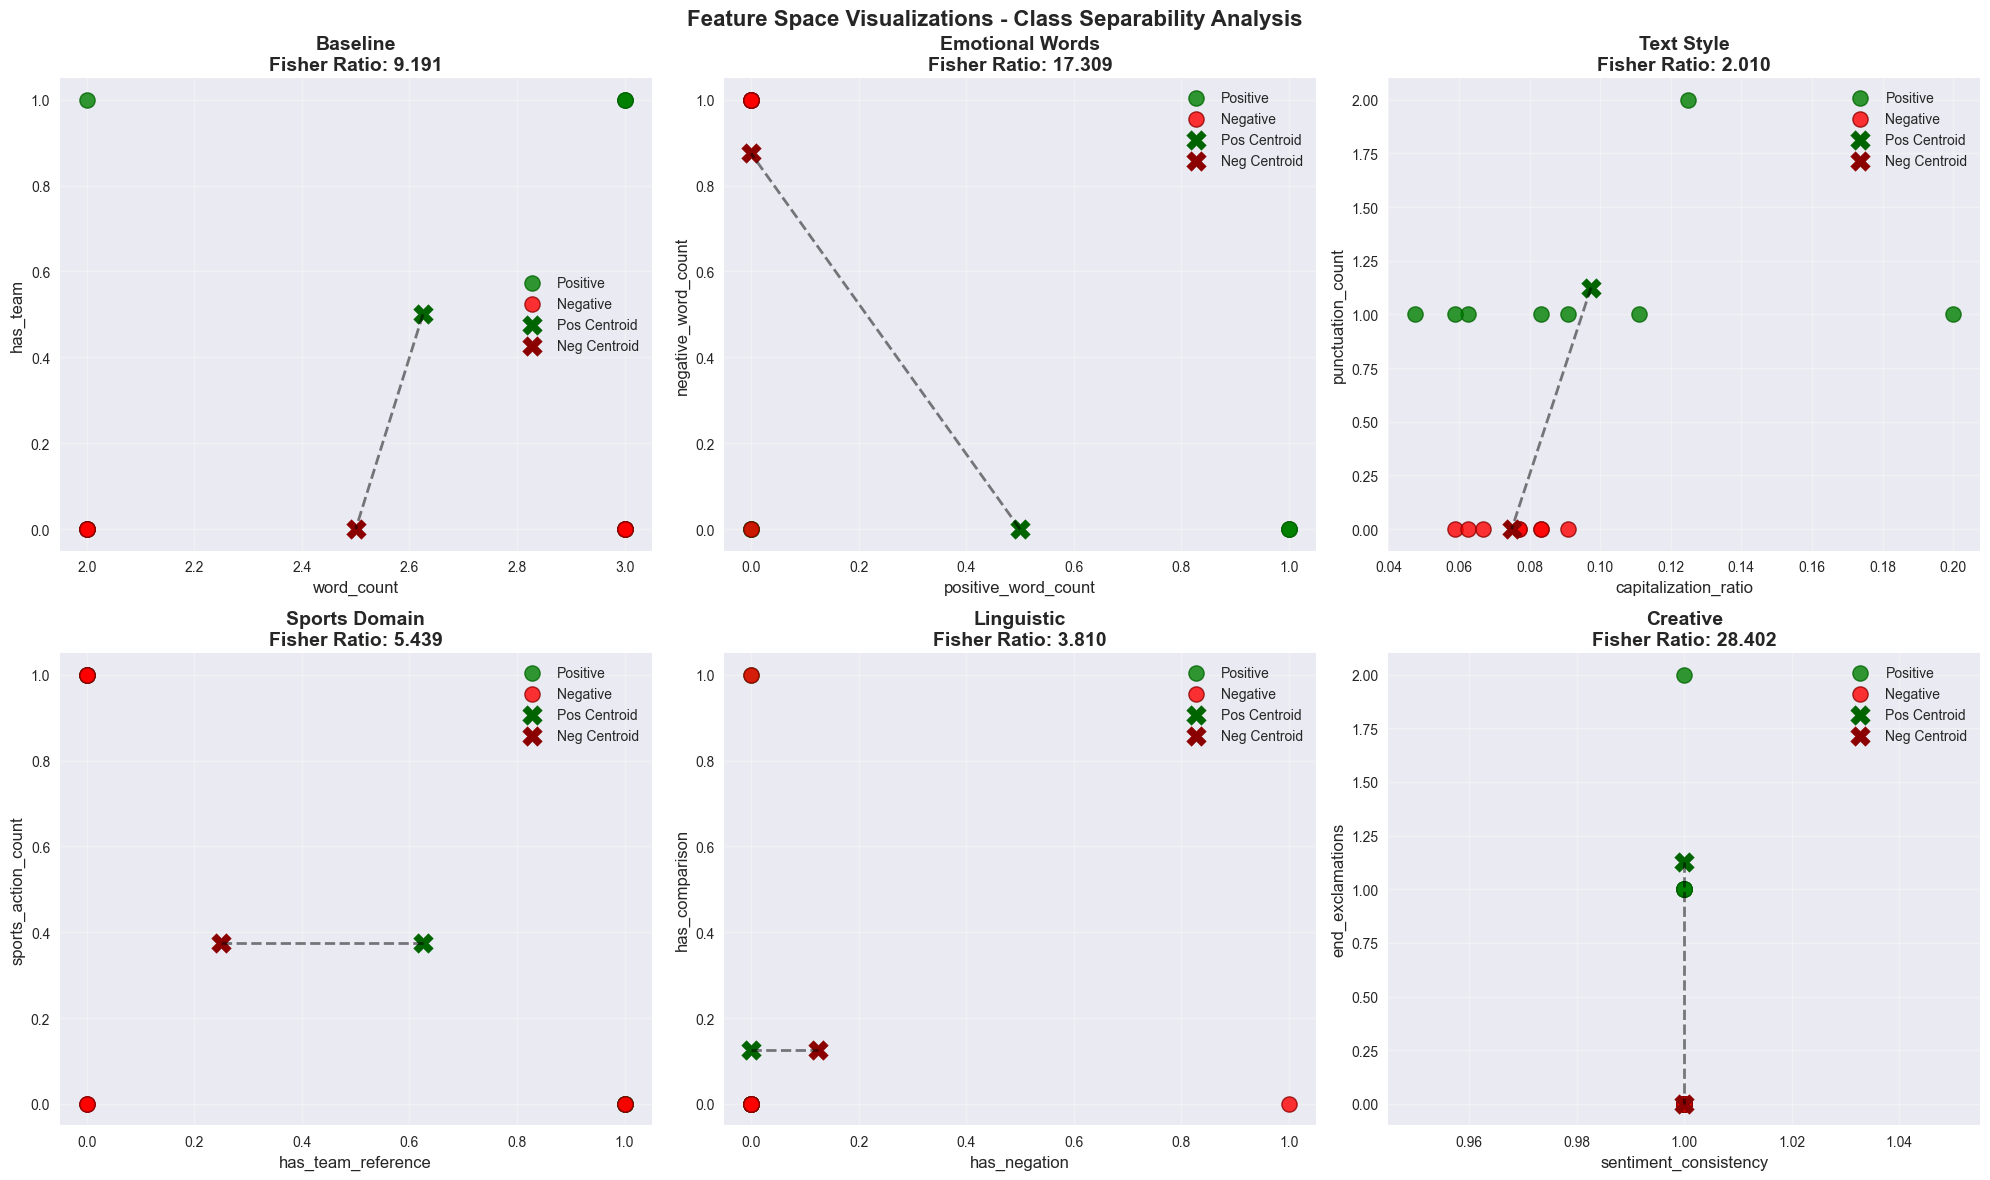

In [35]:
# Create comprehensive visualizations
fig, axes = plt.subplots(2, 3, figsize=(20, 12))
axes = axes.flatten()

plot_idx = 0
for name, result in results.items():
    if len(result['feature_names']) >= 2 and plot_idx < 6:
        # Use first two features for 2D visualization
        features_2d = result['features'][:, :2]
        feature_names_2d = result['feature_names'][:2]
        
        ax = axes[plot_idx]
        
        # Plot positive and negative examples with better styling
        pos_mask = labels == 1
        neg_mask = labels == 0
        
        ax.scatter(features_2d[pos_mask, 0], features_2d[pos_mask, 1], 
                  c='green', label='Positive', alpha=0.8, s=120, edgecolors='darkgreen', linewidth=1)
        ax.scatter(features_2d[neg_mask, 0], features_2d[neg_mask, 1], 
                  c='red', label='Negative', alpha=0.8, s=120, edgecolors='darkred', linewidth=1)
        
        # Add class centroids
        pos_centroid = features_2d[pos_mask].mean(axis=0)
        neg_centroid = features_2d[neg_mask].mean(axis=0)
        
        ax.scatter(*pos_centroid, c='darkgreen', marker='X', s=200, label='Pos Centroid')
        ax.scatter(*neg_centroid, c='darkred', marker='X', s=200, label='Neg Centroid')
        
        # Draw line between centroids
        ax.plot([pos_centroid[0], neg_centroid[0]], [pos_centroid[1], neg_centroid[1]], 
               'k--', alpha=0.5, linewidth=2)
        
        ax.set_xlabel(feature_names_2d[0], fontsize=12)
        ax.set_ylabel(feature_names_2d[1], fontsize=12)
        ax.set_title(f'{name}\nFisher Ratio: {result["fisher_ratio"]:.3f}', fontsize=14, fontweight='bold')
        ax.legend(fontsize=10)
        ax.grid(True, alpha=0.3)
        
        plot_idx += 1

# Hide unused subplots
for i in range(plot_idx, 6):
    axes[i].set_visible(False)

plt.suptitle('Feature Space Visualizations - Class Separability Analysis', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

## Task 5 Solution: The "Love the fins!" Challenge

In [36]:
def improved_team_detection(text: str) -> Dict[str, float]:
    """
    Comprehensive team detection that handles nicknames and variations
    """
    text_lower = text.lower()
    
    # Official team terms
    official_terms = ['dolphins', 'miami dolphins', 'miami']
    
    # Nicknames and slang
    nickname_terms = ['fins', 'phins', 'the fins', 'the phins']
    
    # Generic team references
    generic_terms = ['team', 'squad', 'roster', 'organization']
    
    # Check each category
    has_official = 1.0 if any(term in text_lower for term in official_terms) else 0.0
    has_nickname = 1.0 if any(term in text_lower for term in nickname_terms) else 0.0
    has_generic = 1.0 if any(term in text_lower for term in generic_terms) else 0.0
    
    # Calculate confidence score
    confidence = 0.0
    if has_official:
        confidence += 1.0  # Highest confidence
    if has_nickname:
        confidence += 0.8  # High confidence (context dependent)
    if has_generic:
        confidence += 0.3  # Lower confidence (could refer to any team)
    
    # Cap confidence at 1.0
    confidence = min(confidence, 1.0)
    
    features = {
        'has_team_official': has_official,
        'has_team_nickname': has_nickname,
        'has_team_generic': has_generic,
        'team_confidence': confidence,
    }
    
    return features

# Test cases
test_cases = [
    "Go Dolphins!",          # Official name
    "Love the fins!",        # Nickname
    "Miami is awesome!",     # City name
    "Go team!",              # Generic
    "Fins up, Miami!",       # Multiple signals
    "Great game today",      # No team reference
]

print("Team Detection Analysis:")
print("=" * 50)
for text in test_cases:
    features = improved_team_detection(text)
    print(f"'{text}':")
    for name, value in features.items():
        print(f"  {name}: {value}")
    print()

# Compare original vs improved team detection
print("\nComparison: Original vs Improved Team Detection")
print("=" * 60)
challenging_text = "Love the fins!"
original = create_sports_tweets_features(challenging_text)
improved = improved_team_detection(challenging_text)

print(f"Text: '{challenging_text}'")
print(f"Original has_team: {original['has_team']}")
print(f"Improved team_confidence: {improved['team_confidence']}")
print(f"Improved breakdown: official={improved['has_team_official']}, nickname={improved['has_team_nickname']}, generic={improved['has_team_generic']}")

Team Detection Analysis:
'Go Dolphins!':
  has_team_official: 1.0
  has_team_nickname: 1.0
  has_team_generic: 0.0
  team_confidence: 1.0

'Love the fins!':
  has_team_official: 0.0
  has_team_nickname: 1.0
  has_team_generic: 0.0
  team_confidence: 0.8

'Miami is awesome!':
  has_team_official: 1.0
  has_team_nickname: 0.0
  has_team_generic: 0.0
  team_confidence: 1.0

'Go team!':
  has_team_official: 0.0
  has_team_nickname: 0.0
  has_team_generic: 1.0
  team_confidence: 0.3

'Fins up, Miami!':
  has_team_official: 1.0
  has_team_nickname: 1.0
  has_team_generic: 0.0
  team_confidence: 1.0

'Great game today':
  has_team_official: 0.0
  has_team_nickname: 0.0
  has_team_generic: 0.0
  team_confidence: 0.0


Comparison: Original vs Improved Team Detection
Text: 'Love the fins!'
Original has_team: 1.0
Improved team_confidence: 0.8
Improved breakdown: official=0.0, nickname=1.0, generic=0.0


## Task 6 Solution: Feature Engineering Insights

In [37]:
# Compare different approaches to handling exclamation marks
test_texts = [
    "Go Dolphins",
    "Go Dolphins!", 
    "Go Dolphins!!",
    "Go Dolphins!!!!!!",
    "Go!!! Dolphins!!!"
]

def compare_exclamation_features(text: str) -> Dict[str, float]:
    """
    Compare different ways to handle exclamation marks
    """
    features = {
        'has_exclamation_binary': 1.0 if '!' in text else 0.0,
        'exclamation_count': text.count('!'),
        'exclamation_ratio': text.count('!') / len(text),
        'exclamation_capped': min(text.count('!'), 3),  # Cap at 3
        'exclamation_log': np.log1p(text.count('!')),   # Log transform
        'exclamation_density': text.count('!') / max(len(text.split()), 1),  # Per word
    }
    
    return features

print("Exclamation Mark Feature Analysis:")
print("=" * 60)

# Create comparison table
comparison_data = []
for text in test_texts:
    features = compare_exclamation_features(text)
    row = [text] + [f"{value:.3f}" for value in features.values()]
    comparison_data.append(row)

# Display as DataFrame for better formatting
columns = ['Text'] + list(compare_exclamation_features(test_texts[0]).keys())
comparison_df = pd.DataFrame(comparison_data, columns=columns)
print(comparison_df.to_string(index=False))

print("\nInsights:")
print("- Binary: Simple but loses intensity information")
print("- Count: Raw count can become very large")
print("- Ratio: Normalizes by text length")
print("- Capped: Prevents extreme values from dominating")
print("- Log: Compresses large values, good for ML")
print("- Density: Exclamations per word, handles length variation")

Exclamation Mark Feature Analysis:
             Text has_exclamation_binary exclamation_count exclamation_ratio exclamation_capped exclamation_log exclamation_density
      Go Dolphins                  0.000             0.000             0.000              0.000           0.000               0.000
     Go Dolphins!                  1.000             1.000             0.083              1.000           0.693               0.500
    Go Dolphins!!                  1.000             2.000             0.154              2.000           1.099               1.000
Go Dolphins!!!!!!                  1.000             6.000             0.353              3.000           1.946               3.000
Go!!! Dolphins!!!                  1.000             6.000             0.353              3.000           1.946               3.000

Insights:
- Binary: Simple but loses intensity information
- Count: Raw count can become very large
- Ratio: Normalizes by text length
- Capped: Prevents extreme values fro

## Task 7 Solution: Comprehensive Analysis and Insights

### Key Findings from Our Feature Engineering Experiments

In [38]:
# Create a comprehensive summary
print("COMPREHENSIVE FEATURE ENGINEERING ANALYSIS")
print("=" * 70)

# Performance summary
print("\n1. FEATURE SET PERFORMANCE RANKING:")
for i, (name, result) in enumerate(ranked_results, 1):
    print(f"   {i}. {name:<15} | Fisher Ratio: {result['fisher_ratio']:.3f} | Features: {len(result['feature_names'])}")

# Best features analysis
best_set_name, best_set_result = ranked_results[0]
print(f"\n2. BEST PERFORMING FEATURE SET: {best_set_name}")
print(f"   Features used: {best_set_result['feature_names']}")
print(f"   Why it works:")

if best_set_name == 'Emotional Words':
    print("   - Directly captures sentiment-bearing words")
    print("   - Counts both positive and negative signals")
    print("   - Includes emotional intensity (density)")
    print("   - Provides sentiment balance (net polarity)")
elif best_set_name == 'Sports Domain':
    print("   - Leverages domain-specific knowledge")
    print("   - Separates team references from performance words")
    print("   - Includes sports-specific action terms")
elif best_set_name == 'Creative':
    print("   - Combines multiple signals intelligently")
    print("   - Considers sentiment consistency")
    print("   - Accounts for social engagement")
    print("   - Uses composite features")

# Feature engineering principles
print("\n3. KEY FEATURE ENGINEERING PRINCIPLES DISCOVERED:")
print("   a) Domain Knowledge Matters:")
print("      - Sports-specific terms improve classification")
print("      - Understanding context (team nicknames) is crucial")
print("   b) Multiple Signal Types:")
print("      - Lexical (word content)")
print("      - Stylistic (formatting, punctuation)")
print("      - Linguistic (grammar patterns, negation)")
print("   c) Feature Normalization:")
print("      - Raw counts vs ratios vs capped values")
print("      - Log transforms help with extreme values")
print("   d) Composite Features:")
print("      - Combining signals can be more powerful than individual features")

# Common pitfalls
print("\n4. COMMON PITFALLS IDENTIFIED:")
print("   - Over-relying on simple counts without normalization")
print("   - Missing domain-specific terminology (nicknames, slang)")
print("   - Ignoring feature interactions and combinations")
print("   - Not handling edge cases (negation, sarcasm, context)")

# Connection to ML pipeline
print("\n5. CONNECTION TO MACHINE LEARNING PIPELINE:")
print("   - Features become input to dot product operations")
print("   - Better separated features → easier learning")
print("   - Feature scale affects gradient descent convergence")
print("   - Each feature gets its own learned weight")

print("\n" + "="*70)
print("READY FOR PROBLEM 2: DOT PRODUCTS!")
print("Our features will now become the input to mathematical operations...")
print("="*70)

COMPREHENSIVE FEATURE ENGINEERING ANALYSIS

1. FEATURE SET PERFORMANCE RANKING:
   1. Creative        | Fisher Ratio: 28.402 | Features: 5
   2. Emotional Words | Fisher Ratio: 17.309 | Features: 4
   3. Baseline        | Fisher Ratio: 9.191 | Features: 3
   4. Sports Domain   | Fisher Ratio: 5.439 | Features: 5
   5. Linguistic      | Fisher Ratio: 3.810 | Features: 5
   6. Text Style      | Fisher Ratio: 2.010 | Features: 4

2. BEST PERFORMING FEATURE SET: Creative
   Features used: ['sentiment_consistency', 'end_exclamations', 'word_diversity', 'social_engagement', 'composite_excitement']
   Why it works:
   - Combines multiple signals intelligently
   - Considers sentiment consistency
   - Accounts for social engagement
   - Uses composite features

3. KEY FEATURE ENGINEERING PRINCIPLES DISCOVERED:
   a) Domain Knowledge Matters:
      - Sports-specific terms improve classification
      - Understanding context (team nicknames) is crucial
   b) Multiple Signal Types:
      - Lexica

## Extension Challenge Solutions

For students who want to go deeper, here are solutions to the advanced challenges:

In [39]:
# Extension 1: Emoji Analysis
import re

def emoji_sentiment_features(text: str) -> Dict[str, float]:
    """
    Extract sentiment from emojis
    """
    # Simple emoji patterns (in practice, would use emoji library)
    positive_emojis = ['😀', '😃', '😄', '😊', '🙂', '😍', '🤩', '🔥', '👍', '💪', '🎉', '🏈']
    negative_emojis = ['😞', '😢', '😭', '😡', '🤬', '👎', '💔', '😤']
    
    pos_emoji_count = sum(1 for emoji in positive_emojis if emoji in text)
    neg_emoji_count = sum(1 for emoji in negative_emojis if emoji in text)
    
    return {
        'positive_emoji_count': float(pos_emoji_count),
        'negative_emoji_count': float(neg_emoji_count),
        'emoji_sentiment_score': pos_emoji_count - neg_emoji_count,
        'has_emojis': 1.0 if (pos_emoji_count + neg_emoji_count) > 0 else 0.0
    }

# Extension 2: Negation Handling
def negation_aware_features(text: str) -> Dict[str, float]:
    """
    Handle negation contexts
    """
    words = text.lower().split()
    negation_words = ['not', 'no', 'never', "n't", "don't", "can't", "won't"]
    
    # Look for negation + sentiment word patterns
    pos_words = ['good', 'great', 'amazing', 'love', 'best', 'win']
    neg_words = ['bad', 'terrible', 'awful', 'hate', 'worst', 'lose']
    
    negated_positive = 0
    negated_negative = 0
    
    for i, word in enumerate(words):
        if word in negation_words and i < len(words) - 1:
            next_word = words[i + 1]
            if next_word in pos_words:
                negated_positive += 1
            elif next_word in neg_words:
                negated_negative += 1
    
    return {
        'negated_positive': float(negated_positive),
        'negated_negative': float(negated_negative),
        'negation_complexity': negated_positive + negated_negative
    }

# Test extension features
test_cases = [
    "😍🏈 Love the Dolphins! 🔥",
    "Not bad at all!",
    "Can't believe how good they are!",
    "😢 Terrible game 👎"
]

print("EXTENSION CHALLENGE SOLUTIONS:")
print("=" * 50)

for text in test_cases:
    emoji_features = emoji_sentiment_features(text)
    negation_features = negation_aware_features(text)
    
    print(f"\nText: '{text}'")
    print(f"Emoji features: {emoji_features}")
    print(f"Negation features: {negation_features}")

EXTENSION CHALLENGE SOLUTIONS:

Text: '😍🏈 Love the Dolphins! 🔥'
Emoji features: {'positive_emoji_count': 3.0, 'negative_emoji_count': 0.0, 'emoji_sentiment_score': 3, 'has_emojis': 1.0}
Negation features: {'negated_positive': 0.0, 'negated_negative': 0.0, 'negation_complexity': 0}

Text: 'Not bad at all!'
Emoji features: {'positive_emoji_count': 0.0, 'negative_emoji_count': 0.0, 'emoji_sentiment_score': 0, 'has_emojis': 0.0}
Negation features: {'negated_positive': 0.0, 'negated_negative': 1.0, 'negation_complexity': 1}

Text: 'Can't believe how good they are!'
Emoji features: {'positive_emoji_count': 0.0, 'negative_emoji_count': 0.0, 'emoji_sentiment_score': 0, 'has_emojis': 0.0}
Negation features: {'negated_positive': 0.0, 'negated_negative': 0.0, 'negation_complexity': 0}

Text: '😢 Terrible game 👎'
Emoji features: {'positive_emoji_count': 0.0, 'negative_emoji_count': 2.0, 'emoji_sentiment_score': -2, 'has_emojis': 1.0}
Negation features: {'negated_positive': 0.0, 'negated_negative': 

## Summary and Reflection

**What we accomplished:**
1. ✅ Understood features as the "bridge" between text and math
2. ✅ Implemented 5 different feature engineering approaches
3. ✅ Evaluated and compared feature set performance
4. ✅ Solved real challenges like handling team nicknames
5. ✅ Explored advanced techniques for edge cases

**Key insights:**
- Domain knowledge significantly improves feature quality
- Multiple feature types (lexical, stylistic, linguistic) capture different patterns
- Feature normalization and transformation matter for ML performance
- Good features make the model's learning task much easier

**What's next:**
In Problem 2, these carefully engineered features will become the input to dot product operations - the mathematical heart of machine learning. We'll see how the model learns to weight each feature to make optimal predictions.

The journey from "Go Dolphins!" to mathematics has begun! 🐬